# Fraud classifier | Training the classifier
Let's try to develop a model basedo n the assumption that everything is ok with our dataset, and understand how good is our classifier to indetify fraudulent events.
Here we've decided to develop a classifier using [RandomForest from the scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) package.

In [1]:
%%capture
!pip install xgboost

#### Import the needed packages

In [2]:
import os
import base64

import pandas as pd
import matplotlib.pyplot as plt

from functions.saving_functions import read_file, save_file

#Using XGBOOST model to train the model
from xgboost import XGBClassifier

#Data scaling and preprocessing before training the model
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score,roc_auc_score, precision_score, recall_score

from sklearn.model_selection import train_test_split

#### Auxiliary functions

In [3]:
def preprocess_df(df, std_scaler, rob_scaler):
    df['Amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
    return df

In [4]:
#Function to define the classifier to be used
def XGBoost_Classifier(X, y, Xtest):
    """XGBoost training code"""
    classifier = XGBClassifier()
    print('Start fitting XGBoost classifier')
    classifier.fit(X, y)
    y_pred = classifier.predict(Xtest)
    print('Classifier trained.')
    return classifier, y_pred

In [5]:
def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    fig, axes = plt.subplots(1,2,figsize=(20,8))
    for (title, normalize), ax in zip(titles_options, axes):

        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Normal", "Fraud"],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize,
                                     ax=ax)

        ax.set_title(title, fontsize=20, pad=10)
    
    return ax

In [6]:
fn_metrics = {
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score
}

#### Getting the environment configurations

In [17]:
path = os.getenv('DATA_PATH', 'data.pkl')

### Reading the dataset

In [18]:
data = read_file(path)

pipeline_config = read_file('pipeline_config.pkl')

#### Preparing the data for the classifier

In [19]:
X = data.drop('Class', axis=1)
cols = X.columns
X = X.values
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  199370
Number transactions test dataset:  85445
Total number of transactions:  284815


In [20]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [21]:
stdscaler = StandardScaler()
robscaler = RobustScaler()

X_train = preprocess_df(X_train, stdscaler, robscaler)
X_test = preprocess_df(X_test, stdscaler, robscaler)

In [22]:
classifier_model, y_pred = XGBoost_Classifier(X_train, y_train, X_test)

Start fitting XGBoost classifier
Classifier trained.


In [23]:
metrics = {}

for k, metric in fn_metrics.items():
    metrics[k]=metric(y_true = y_test, y_pred=y_pred)

In [25]:
# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.999777634735795
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85290
       Fraud       0.97      0.90      0.94       155

    accuracy                           1.00     85445
   macro avg       0.99      0.95      0.97     85445
weighted avg       1.00      1.00      1.00     85445



#### Output the confusion matrix

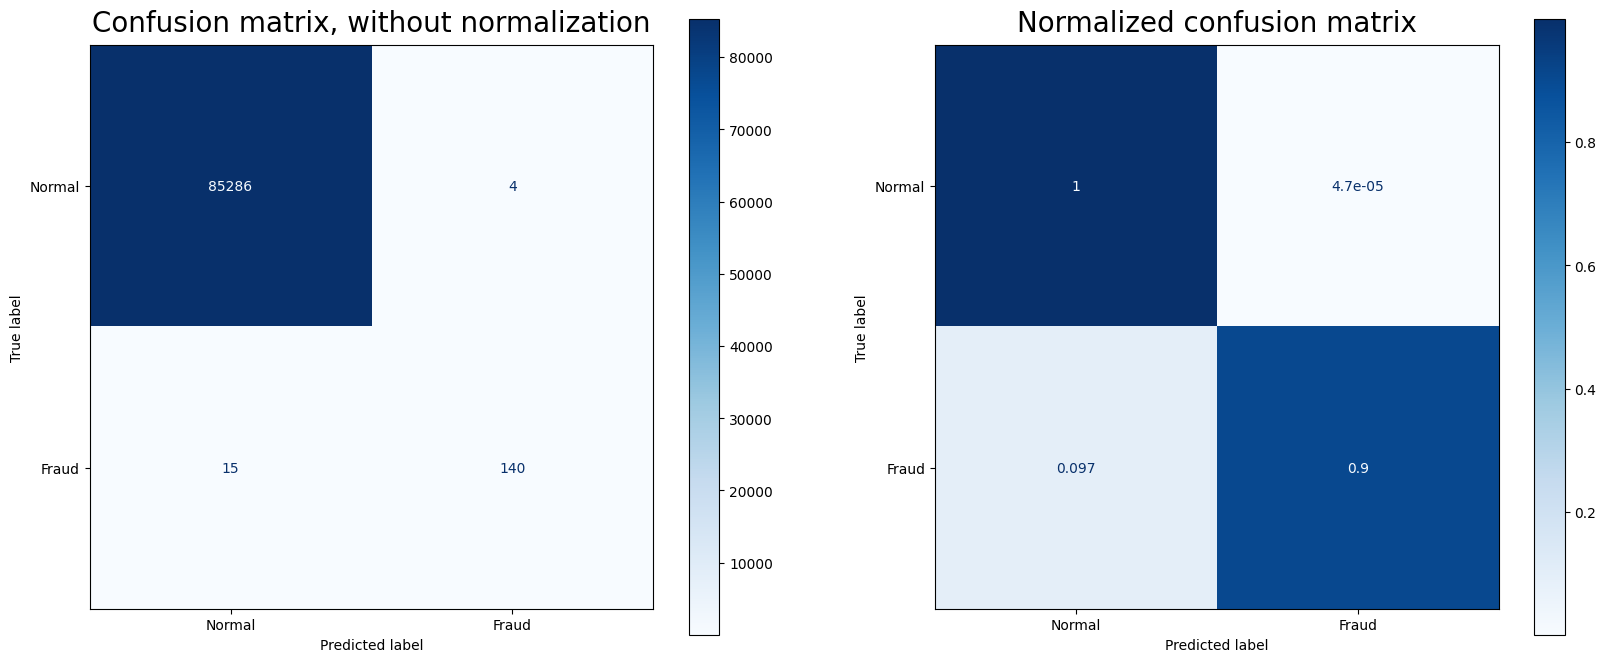

In [26]:
cnf_matrix = print_confusion_matrix(classifier_model, X_test, y_test)

plt.savefig('cnf_matrix.png')

matrix_graph = open('cnf_matrix.png', 'rb').read() # read bytes from file
matrix_graph = base64.b64encode(matrix_graph)  # encode to base64 (bytes)
matrix_graph = matrix_graph.decode()

html_matrix = f"""
<body>
<h2>Confusion Matrix</h2>
<p style="text-align:center;"><img src="data:image/png;base64,{matrix_graph}"></p>
</body>
"""

### Prepare the pipeline outputs

In [27]:
import json

profile_pipeline_output = {
    'outputs' : [
    {
      'type': 'web-app',
      'storage': 'inline',
      'source': html_matrix,
    },
    ]
  }

with open('mlpipeline-ui-metadata.json', 'w') as metadata_file:
    json.dump(profile_pipeline_output, metadata_file)

In [28]:
metrics = {
'metrics': [
    {
        'name': 'f1-score',
        'numberValue':  metrics["f1"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'precision',
        'numberValue':  metrics["precision"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'recall',
        'numberValue':  metrics["recall"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'y-sample-size',
        'numberValue':  pipeline_config['sample_size'],
        'format': 'RAW'  
    },
    {
        'name': 'y-augment',
        'numberValue':  pipeline_config['augment'],
        'format': 'RAW'  
    }
]
}
with open('mlpipeline-metrics.json', 'w') as f:
    json.dump(metrics, f)